In [ ]:
# ==============================
# Analisis Opini Publik - Wisata Bantul
# ==============================

import time
import urllib.parse
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

import string

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# stopwords Indonesia
extra_stopwords = set([
    # kata umum tidak informatif
    "wisata","bantul","daerah","lokasi","jogja","yogyakarta","diy",
    "tempat","jalan","hari","banget","bgt","kayak","mungkin","orang",
    "aja","sih","nih","tuh","yaa","ya","loh","lho","dong","deh",
    "itu","ini","buat","bikin","jadi","guna","udah","lagi","bang",
    "min","kak","bro",

    # noise twitter
    "rt","gw","gue","gua","aku","kamu","lu","loe","yaaa","hehe",
    "wkwk","wkwkwk","iya","nggak","gak","ga",

    # kata travel yg tidak spesifik destinasi
    "jalanjalan","travel","trip","visit","tour","liburan","holiday"
])

base_stopwords = set(stopwords.words("indonesian"))

all_stopwords = base_stopwords.union(extra_stopwords)

def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    text = text.lower()

    # hapus URL
    text = re.sub(r"http\S+|www\.\S+", " ", text)

    # hapus username
    text = re.sub(r"@\w+", " ", text)

    # hapus angka
    text = re.sub(r"\d+", " ", text)

    # hapus tanda baca
    text = text.translate(str.maketrans("", "", string.punctuation))

    # hapus emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(" ", text)

    # tokenisasi
    tokens = text.split()

    # hapus stopwords + token pendek
    tokens = [t for t in tokens if t not in all_stopwords and len(t) > 2]

    return " ".join(tokens).strip()


In [4]:
# ------------------ SETTINGS ------------------
TARGET_COUNT = 110        # target jumlah dokumen final (clean & dedup)
PER_QUERY_LIMIT = 50      # minta sampai 50 per request (tergantung api)
API_SLEEP = 6            
MIN_LEN_CLEAN = 10        # minimal panjang teks setelah cleaning

# list seed queries yang lebih variatif (term, hashtag, variasi ejaan)
seed_queries = [
    "wisata bantul",
    "wisata daerah bantul",
    "pantai parangtritis",
    "parangtritis",
    "heha ocean view",
    "heha",
    "hutan pinus mangunan",
    "mangunan",
    "pintu langit dahromo",
    "#wisatabantul",
    "#parangtritis"
]

# ------------------ Collect + Deduplicate + Filter ------------------
def fetch_twitter(query, api_key):
    """Panggilan tunggal ke advanced_search (mengembalikan list tweet dict)."""
    base_url = "https://api.twitterapi.io/twitter/tweet/advanced_search"
    headers = {"X-API-Key": api_key, "Accept": "application/json"}
    params = {"queryType": "Latest", "query": query}
    r = requests.get(base_url, headers=headers, params=params)
    # debug print
    print("Query:", query, "->", r.status_code)
    if r.status_code == 429:
        print("Rate limit, sleep", API_SLEEP, "s")
        time.sleep(API_SLEEP)
        return fetch_twitter(query, api_key)
    if r.status_code != 200:
        print("Error:", r.status_code, r.text[:200])
        return []
    data = r.json()
    return data.get("tweets", [])

def collect_until_target(seed_queries, api_key, target=TARGET_COUNT):
    seen_ids = set()
    docs = []
    qi = 0
    # loop over queries berulang kali sampai target atau sampai max loops to avoid infinite
    loops = 0
    max_loops = 10
    while len(docs) < target and loops < max_loops:
        for q in seed_queries:
            if len(docs) >= target:
                break
            tweets = fetch_twitter(q, api_key)
            for tw in tweets:
                tid = tw.get("id")
                if not tid or tid in seen_ids:
                    continue
                # language filter: ambil hanya 'in' jika tersedia (lebih relevan)
                if tw.get("lang") and tw.get("lang") != "in":
                    continue
                text = tw.get("text","") or ""
                # basic filter: buang tweet yang hanya berisi link atau berupa retweet/headline saja
                # if contains many URLs or starts with "RT" then skip
                if text.strip().lower().startswith("rt "):
                    continue
                if text.count("http") >= 2:
                    # kemungkinan hanya link gallery/news, skip
                    continue
                # build doc
                doc = {
                    "source": "twitter",
                    "id": tid,
                    "url": tw.get("url"),
                    "review_text": text,
                    "createdAt": tw.get("createdAt"),
                    "author": tw.get("author", {}).get("name",""),
                    "username": tw.get("author", {}).get("userName",""),
                    "followers": tw.get("author", {}).get("followers",0),
                    "likeCount": tw.get("likeCount",0),
                    "retweetCount": tw.get("retweetCount",0)
                }
                # quick length check
                if len(re.sub(r'\s+',' ', doc["review_text"]).strip()) < MIN_LEN_CLEAN:
                    continue
                seen_ids.add(tid)
                docs.append(doc)
                if len(docs) >= target:
                    break
            # respect rate limit
            time.sleep(API_SLEEP)
        loops += 1
        # if loops exhausted, try expanding queries by removing strict seeds or lowering filters
        if loops == max_loops and len(docs) < target:
            print("Max loops reached but target belum terpenuhi:", len(docs))
            break
    return docs

# ------------------ RUN COLLECTION ------------------
API_KEY = "new1_68b278d5dc78461d8bb8c099b43b5f54"  # ganti sesuai milikmu
docs = collect_until_target(seed_queries, API_KEY, target=TARGET_COUNT)
print("Collected raw docs:", len(docs))

# Save raw fetch
raw_df = pd.DataFrame(docs)
raw_df.to_csv("twitter_raw_collected.csv", index=False, encoding="utf-8-sig")

Query: wisata bantul -> 200
Query: wisata daerah bantul -> 200
Query: pantai parangtritis -> 200
Query: parangtritis -> 200
Query: heha ocean view -> 200
Query: heha -> 200
Query: hutan pinus mangunan -> 200
Query: mangunan -> 200
Query: pintu langit dahromo -> 200
Collected raw docs: 110


After cleaning: 110 documents
Top TF-IDF terms:
                    term     score
0              mangunan  0.050331
1                pantai  0.035444
2                 pinus  0.033328
3          parangtritis  0.033242
4           hutan pinus  0.032262
5                 hutan  0.032262
6        pinus mangunan  0.031996
7   pantai parangtritis  0.023057
8                  view  0.019045
9                  heha  0.018951
10                pintu  0.017582
11               langit  0.016790
12           ocean view  0.016496
13                ocean  0.016496
14           heha ocean  0.016184


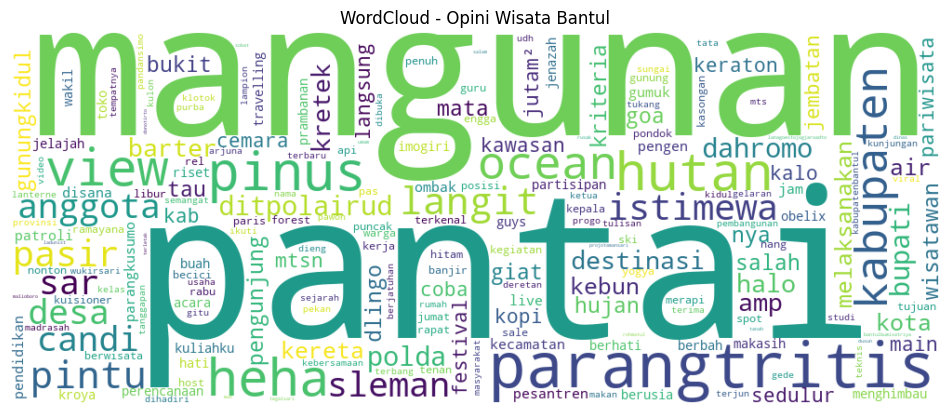

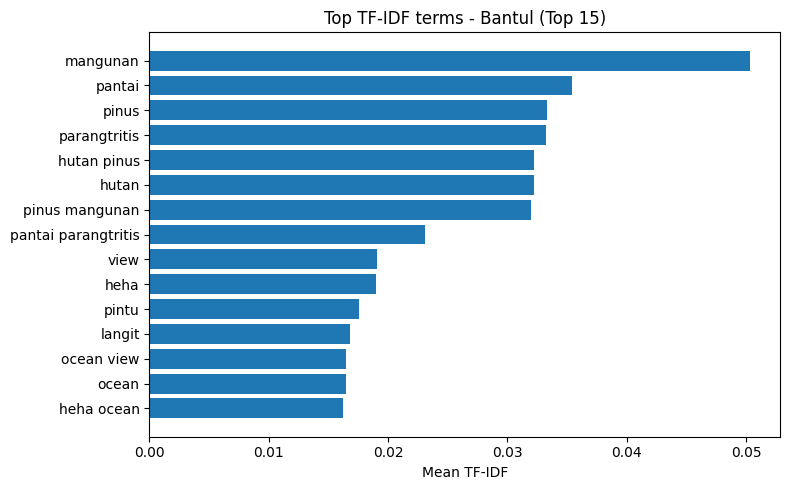

Saved cleaned and final results.


In [5]:
# ------------------ Preprocessing ------------------
df = raw_df.copy()
df['clean'] = df['review_text'].fillna("").apply(preprocess_text)


df = df[df['clean'].str.strip().str.len() > 3].reset_index(drop=True)
print("After cleaning:", len(df), "documents")

df.to_csv("bantul_reviews_clean.csv", index=False, encoding="utf-8-sig")

# ------------------ TF-IDF & Top terms ------------------
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=5000)
X = tfidf.fit_transform(df['clean'])

terms = tfidf.get_feature_names_out()
means = np.asarray(X.mean(axis=0)).ravel()

top_n = 15
top_idx = means.argsort()[::-1][:top_n]
top_terms = terms[top_idx]
top_scores = means[top_idx]

top_df = pd.DataFrame({"term": top_terms, "score": top_scores})
print("Top TF-IDF terms:\n", top_df)

top_df.to_csv("bantul_tfidf_top_terms.csv", index=False, encoding="utf-8-sig")

# ------------------ WordCloud ------------------
all_text = " ".join(df['clean'].tolist())

wc = WordCloud(
    width=1000, height=400, 
    collocations=False, background_color="white"
).generate(all_text)

plt.figure(figsize=(12,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Opini Wisata Bantul")
plt.show()

# ------------------ Bar chart ------------------
plt.figure(figsize=(8,5))
plt.barh(top_df['term'][::-1], top_df['score'][::-1])
plt.xlabel("Mean TF-IDF")
plt.title(f"Top TF-IDF terms - Bantul (Top {top_n})")
plt.tight_layout()
plt.show()

# Save final dataframe
df.to_csv("bantul_reviews_final.csv", index=False, encoding="utf-8-sig")
print("Saved cleaned and final results.")